Credits : https://towardsdatascience.com/a-gentle-introduction-to-self-training-and-semi-supervised-learning-ceee73178b38

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings, time
warnings.filterwarnings('ignore')

### Heart Disease Dataset

In [2]:
data = pd.read_pickle("./pickle_files/heart_data_pre_processed.pkl")
data

,major_vessels_num_0,major_vessels_num_1,major_vessels_num_2,major_vessels_num_3,major_vessels_num_4,exercise_induced_angina_0,exercise_induced_angina_1,sex_0,sex_1,slope_st_0,...,thalassemia_1,thalassemia_2,thalassemia_3,maximum_heart_rate,oldpeak,chest_pain_0,chest_pain_1,chest_pain_2,chest_pain_3,target
0,1,0,0,0,0,1,0,0,1,1,...,1,0,0,0.603053,0.370968,0,0,0,1,1
1,1,0,0,0,0,1,0,0,1,1,...,0,1,0,0.885496,0.564516,0,0,1,0,1
2,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0.770992,0.225806,0,1,0,0,1
3,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0.816794,0.129032,0,1,0,0,1
4,1,0,0,0,0,0,1,1,0,0,...,0,1,0,0.702290,0.096774,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,0,0,0,0,0,1,1,0,0,...,0,0,1,0.396947,0.032258,1,0,0,0,0
299,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0.465649,0.193548,0,0,0,1,0
300,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0.534351,0.548387,1,0,0,0,0
301,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0.335878,0.193548,1,0,0,0,0


In [3]:
X = data.drop(columns=['target'])
y = data['target']

### Applying the Self-training algorithm on the Heart Disease Dataset

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, roc_auc_score,roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

def get_scores(y_test, y_predictions):
    """returns the accuracy and the F1 score for the following predictions"""
    f1_res = f1_score(y_test, y_predictions)
    accuracy = accuracy_score(y_test, y_predictions)
    return f1_res, accuracy

In [5]:
def model(clf,X_train,X_test,y_train,y_test):
    """
    builds the model with the passed classifier,
    predicts the test data,
    prints the confusion matrix,
    returns the f1 and accuracy score,
    """
    
    clf.fit(X_train, y_train)
    
    #predictions
    prediction = clf.predict(X_test)
    predict_proba_values = clf.predict_proba(X_test)
    # f1 and accuracy scores
    score_f1, score_acc = get_scores(y_test, prediction)
    
    print("-"*60)
    print(f"Test Scores : {clf}\nAccuracy:{score_acc}\tF1 Score:{score_f1}")
    print("-"*60)
    print(plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true'))
    
    return score_acc, score_f1,predict_proba_values

In [6]:
def plot_roc(y_test, predict_proba_value):
    """
    plots the roc curve based on y_test and predcit_proba value
    """
    fpr, tpr, _ = roc_curve(y_test, predict_proba_value[:,[1]])
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    return fpr, tpr

Dictionary that holds the final results

In [7]:
final_scores = {}
time_elapsed = {}

In [8]:
# The paramerter grid for Random Forest Algorithm
param_grid_rf = { 
    'n_estimators': [100,150,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9],
    'criterion' :['gini', 'entropy']
}

#### Fully Supervised

In [9]:
# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

RandomForestClassifier(criterion='entropy', max_depth=3, n_jobs=-1,
                       random_state=55)
------------------------------------------------------------
Test Scores : RandomForestClassifier(criterion='entropy', max_depth=3, n_jobs=-1,
                       random_state=55)
Accuracy:0.84	F1 Score:0.8620689655172413
------------------------------------------------------------


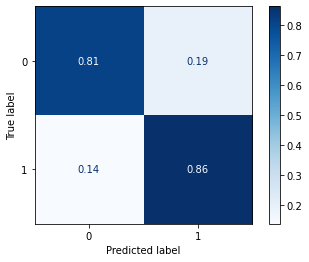

In [10]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
rf_clf = RandomForestClassifier(random_state=55, n_jobs=-1)
grid_rf1 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf1.fit(X_train, y_train)
print(grid_rf1.best_estimator_)

rf_acc, rf_f1, rf_pp = model(grid_rf1.best_estimator_, X_train,X_test,y_train,y_test)
end_time = time.time()
final_scores[("Fully Supervised Accuracy", "Fully Supervised F1 Score")] = (rf_acc,rf_f1)


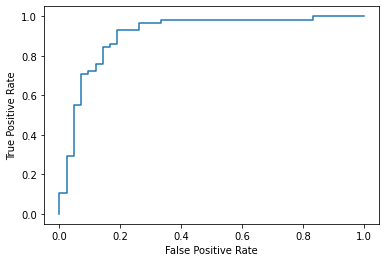

In [11]:
rf1_fpr, rf1_tpr = plot_roc(y_test, rf_pp)

In [12]:
time_elapsed["Fully Supervised"] = end_time-start_time
print(f"Time Elapsed : 100% Supervised Data : {end_time-start_time}")

Time Elapsed : 100% Supervised Data : 25.82628607749939


#### 10% Unlabelled Data

In [13]:
df = data.sample(frac=1, random_state=50)
df.head()

,major_vessels_num_0,major_vessels_num_1,major_vessels_num_2,major_vessels_num_3,major_vessels_num_4,exercise_induced_angina_0,exercise_induced_angina_1,sex_0,sex_1,slope_st_0,...,thalassemia_1,thalassemia_2,thalassemia_3,maximum_heart_rate,oldpeak,chest_pain_0,chest_pain_1,chest_pain_2,chest_pain_3,target
112,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0.473282,0.032258,0,0,1,0,1
63,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0.465649,0.000000,0,1,0,0,1
270,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0.557252,0.129032,1,0,0,0,0
39,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0.610687,0.129032,0,0,1,0,1
277,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0.534351,0.048387,0,1,0,0,0


In [14]:
# generating the split indices and partition of data
unlabelled_data_ind = round(len(df) * 0.10)
train_ind = unlabelled_data_ind + round(len(df) * 0.60)
test_ind = train_ind + round(len(df) * 0.30)

unlabelled = df.iloc[:unlabelled_data_ind]
train = df.iloc[unlabelled_data_ind:train_ind]
test = df.iloc[train_ind:]

# assigning the data to train, test and unlabelled sets
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_unlabeled = unlabelled.drop('target', axis=1)


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (182, 22)
y_train dimensions: (182,)

X_test dimensions: (91, 22)
y_test dimensions: (91,)

X_unlabeled dimensions: (30, 22)


Class Distirbution; almost identical

<AxesSubplot:>

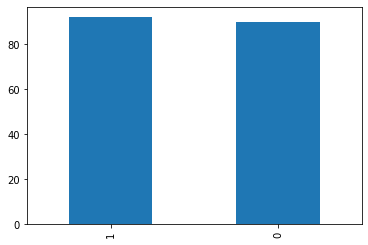

In [15]:
y_train.value_counts().plot(kind='bar')

STEPS followed : 
- Train a Random Forest Classifier on the labelled data
- Use this classifier to predict labels for the unlabelled data, adopt pseudo-lables with prediction probability greater or equal to 95
- Concatenate the ‘pseudo-labeled’ data with the labeled training data, and re-train the classifier on the concatenated data.
- Use trained classifier to make predictions for the labeled test data, and evaluate the classifier.
- Repeat these steps until no more predictions have a probability greater than 98

RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=55)
------------------------------------------------------------
Test Scores : RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=55)
Accuracy:0.8021978021978022	F1 Score:0.8363636363636364
------------------------------------------------------------


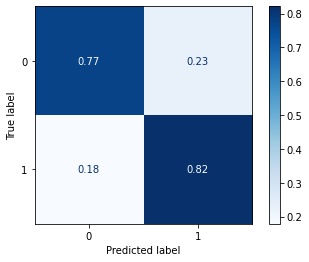

In [16]:
# initial classifier on this data
start_time = time.time()
grid_rf2 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf2.fit(X_train, y_train)
print(grid_rf2.best_estimator_)

rf2_acc, rf2_f1, rf2_pp = model(grid_rf2.best_estimator_, X_train,X_test,y_train,y_test)

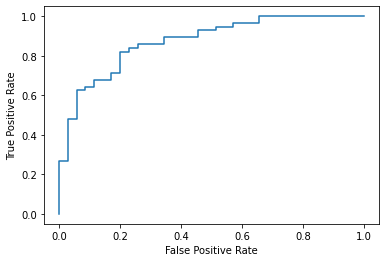

In [17]:
_, _ = plot_roc(y_test, rf2_pp)

In [18]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = grid_rf2.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    test_f1, test_acc = get_scores(y_test, y_pred)
    print(f"Iteration {iterations}")
    print(f"Accuracy : {test_acc}\tF1 Score ; {test_f1}")
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 95% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.98],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.98]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

end_time = time.time()

Iteration 0
Accuracy : 0.8021978021978022	F1 Score ; 0.8363636363636364
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 1
Accuracy : 0.8131868131868132	F1 Score ; 0.8468468468468467
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.



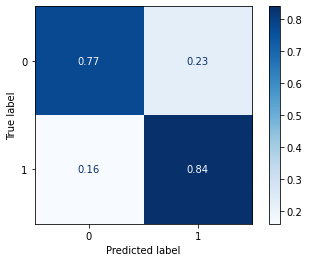

In [19]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true')

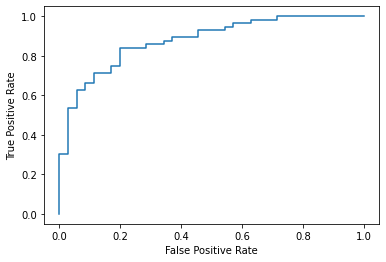

In [20]:
rf2_fpr, rf2_tpr = plot_roc(y_test, clf.predict_proba(X_test))

In [21]:
final_scores[('10% Unlabelled Data Accuracy', '10% Unlabelled Data F1 score')] = (test_acc, test_f1)
time_elapsed["10% Unlabelled"] = end_time-start_time
print(f"Time Elapsed, 10% Unlabelled Data : {end_time - start_time}")

Time Elapsed, 10% Unlabelled Data : 27.506192207336426


#### 20% unlabelled data

In [22]:
df = data.sample(frac=1, random_state=50)
df.head()

,major_vessels_num_0,major_vessels_num_1,major_vessels_num_2,major_vessels_num_3,major_vessels_num_4,exercise_induced_angina_0,exercise_induced_angina_1,sex_0,sex_1,slope_st_0,...,thalassemia_1,thalassemia_2,thalassemia_3,maximum_heart_rate,oldpeak,chest_pain_0,chest_pain_1,chest_pain_2,chest_pain_3,target
112,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0.473282,0.032258,0,0,1,0,1
63,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0.465649,0.000000,0,1,0,0,1
270,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0.557252,0.129032,1,0,0,0,0
39,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0.610687,0.129032,0,0,1,0,1
277,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0.534351,0.048387,0,1,0,0,0


In [23]:
# generating the split indices and partition of data
unlabelled_data_ind = round(len(df) * 0.20)
train_ind = unlabelled_data_ind + round(len(df) * 0.60)
test_ind = train_ind + round(len(df) * 0.20)

unlabelled = df.iloc[:unlabelled_data_ind]
train = df.iloc[unlabelled_data_ind:train_ind]
test = df.iloc[train_ind:]

# assigning the data to train, test and unlabelled sets
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_unlabeled = unlabelled.drop('target', axis=1)


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

X_train dimensions: (182, 22)
y_train dimensions: (182,)

X_test dimensions: (60, 22)
y_test dimensions: (60,)

X_unlabeled dimensions: (61, 22)


<AxesSubplot:>

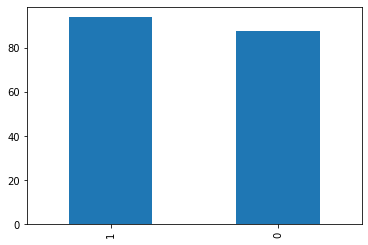

In [24]:
y_train.value_counts().plot(kind='bar')

In [ ]:
# initial classifier on this data
start_time = time.time()
grid_rf3 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf3.fit(X_train, y_train)
print(grid_rf3.best_estimator_)

rf3_acc, rf3_f1, rf3_pp = model(grid_rf3.best_estimator_, X_train,X_test,y_train,y_test)

In [ ]:
_,_ = plot_roc(y_test, rf3_pp)

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = grid_rf3.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    test_f1, test_acc = get_scores(y_test, y_pred)
    print(f"Iteration {iterations}")
    print(f"Accuracy : {test_acc}\tF1 Score ; {test_f1}")
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 95% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.98],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.98]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1
end_time = time.time()

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true')

In [ ]:
rf3_fpr, rf3_tpr = plot_roc(y_test, clf.predict_proba(X_test))

In [ ]:
final_scores[('20% Unlabelled Data Accuracy', '20% Unlabelled Data F1 score')] = (test_acc, test_f1)
time_elapsed["20% Unlabelled"] = end_time-start_time
print(f"Time Elapsed, 20% Unlabelled Data : {end_time - start_time}")

#### 50% Unlabelled Data

In [ ]:
df = data.sample(frac=1, random_state=50)
df.head()

In [ ]:
# generating the split indices and partition of data
unlabelled_data_ind = round(len(df) * 0.50)
train_ind = unlabelled_data_ind + round(len(df) * 0.35)
test_ind = train_ind + round(len(df) * 0.15)

unlabelled = df.iloc[:unlabelled_data_ind]
train = df.iloc[unlabelled_data_ind:train_ind]
test = df.iloc[train_ind:]

# assigning the data to train, test and unlabelled sets
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_unlabeled = unlabelled.drop('target', axis=1)


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

In [ ]:
y_train.value_counts().plot(kind='bar')

In [ ]:
# initial classifier on this data
start_time = time.time()
grid_rf4 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf4.fit(X_train, y_train)
print(grid_rf4.best_estimator_)

rf4_acc, rf4_f1, rf4_pp = model(grid_rf4.best_estimator_, X_train,X_test,y_train,y_test)

In [ ]:
_, _ = plot_roc(y_test, rf4_pp)

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = grid_rf4.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    test_f1, test_acc = get_scores(y_test, y_pred)
    print(f"Iteration {iterations}")
    print(f"Accuracy : {test_acc}\tF1 Score ; {test_f1}")
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 95% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.98],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.98]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1
end_time = time.time()

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true')

In [ ]:
rf4_fpr, rf4_tpr = plot_roc(y_test, clf.predict_proba(X_test))

In [ ]:
final_scores[('50% Unlabelled Data Accuracy', '50% Unlabelled Data F1 score')] = (test_acc, test_f1)
time_elapsed["50% Unlabelled"] = end_time-start_time
print(f"Time Elapsed, 50% Unlabelled Data : {end_time - start_time}")

#### 90% unlabelled data

In [ ]:
df = data.sample(frac=1, random_state=50)
df.head()

In [ ]:
# generating the split indices and partition of data
unlabelled_data_ind = round(len(df) * 0.90)
train_ind = unlabelled_data_ind + round(len(df) * 0.07)
test_ind = train_ind + round(len(df) * 0.03)

unlabelled = df.iloc[:unlabelled_data_ind]
train = df.iloc[unlabelled_data_ind:train_ind]
test = df.iloc[train_ind:]

# assigning the data to train, test and unlabelled sets
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_unlabeled = unlabelled.drop('target', axis=1)


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

In [ ]:
y_train.value_counts().plot(kind='bar')

In [ ]:
# initial classifier on this data
start_time = time.time()
grid_rf5 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf5.fit(X_train, y_train)
print(grid_rf5.best_estimator_)

rf5_acc, rf5_f1, rf5_pp = model(grid_rf5.best_estimator_, X_train,X_test,y_train,y_test)

In [ ]:
_,_ = plot_roc(y_test, rf5_pp)

Probability
- 90%
    - Accuracy : 0.835820895522388	F1 Score ; 0.8196721311475409
- 95%
    - Accuracy : 0.835820895522388	F1 Score ; 0.8196721311475409

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = grid_rf5.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    test_f1, test_acc = get_scores(y_test, y_pred)
    print(f"Iteration {iterations}")
    print(f"Accuracy : {test_acc}\tF1 Score ; {test_f1}")
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 95% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.98],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.98]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1
end_time = time.time()    

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true')

In [ ]:
rf5_fpr, rf5_tpr = plot_roc(y_test, clf.predict_proba(X_test))

In [ ]:
final_scores[('90% Unlabelled Data Accuracy', '90% Unlabelled Data F1 score')] = (test_acc, test_f1)
time_elapsed["90% Unlabelled"] = end_time-start_time
print(f"Time Elapsed, 90% Unlabelled Dataset : {end_time - start_time}")

#### 95% unlabelled data

In [ ]:
df = data.sample(frac=1, random_state=50)
df.head()

In [ ]:
# generating the split indices and partition of data
unlabelled_data_ind = round(len(df) * 0.95)
train_ind = unlabelled_data_ind + round(len(df) * 0.04)
test_ind = train_ind + round(len(df) * 0.01)

unlabelled = df.iloc[:unlabelled_data_ind]
train = df.iloc[unlabelled_data_ind:train_ind]
test = df.iloc[train_ind:]

# assigning the data to train, test and unlabelled sets
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_unlabeled = unlabelled.drop('target', axis=1)


# Check dimensions of data after splitting

print(f"X_train dimensions: {X_train.shape}")
print(f"y_train dimensions: {y_train.shape}\n")

print(f"X_test dimensions: {X_test.shape}")
print(f"y_test dimensions: {y_test.shape}\n")

print(f"X_unlabeled dimensions: {X_unlabeled.shape}")

In [ ]:
y_train.value_counts().plot(kind='bar')

In [ ]:
# initial classifier on this data
start_time = time.time()
grid_rf6 = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, n_jobs=-1)
grid_rf6.fit(X_train, y_train)
print(grid_rf6.best_estimator_)

rf6_acc, rf6_f1, rf6_pp = model(grid_rf6.best_estimator_, X_train,X_test,y_train,y_test)

In [ ]:
_, _ = plot_roc(y_test, rf6_pp)

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = grid_rf6.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    test_f1, test_acc = get_scores(y_test, y_pred)
    print(f"Iteration {iterations}")
    print(f"Accuracy : {test_acc}\tF1 Score ; {test_f1}")
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = clf.predict_proba(X_unlabeled)
    preds = clf.predict(X_unlabeled)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 95% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.98],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.98]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1
end_time = time.time()

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true')

In [ ]:
rf6_fpr, rf6_tpr = plot_roc(y_test, clf.predict_proba(X_test))

In [ ]:
final_scores[('95% Unlabelled Data Accuracy', '95% Unlabelled Data F1 score')] = (test_acc, test_f1)
time_elapsed["95% Unlabelled"] = end_time-start_time
print(f"Time elapsed, 95% Unlabelled Dataset : {end_time - start_time}")

#### FINAL RESULTS

In [ ]:
final_scores

In [ ]:
final_scores_df = pd.DataFrame(data=['Nan'], index=[0])
for key, value in final_scores.items():
    final_scores_df[key[0]] = value[0]
    final_scores_df[key[1]] = value[1]

In [ ]:
final_scores_df.drop(columns=[final_scores_df.columns[0]], inplace=True)
final_scores_df

In [ ]:
plt.plot(rf1_fpr, rf1_tpr,color="orange", label="Fullysupervised")
plt.plot(rf2_fpr, rf2_tpr,color="blue", label="10% Unlabelled Data")
plt.plot(rf3_fpr, rf3_tpr,color="green", label="20% Unlabelled Data")
plt.plot(rf4_fpr, rf4_tpr,color="red", label="50% Unlabelled Data")
plt.plot(rf5_fpr, rf5_tpr,color="yellow", label="90% Unlabelled Data")
plt.plot(rf6_fpr, rf6_tpr,color="black", label="95% Unlabelled Data")
plt.xlabel("False Positive Rate")
plt.ylabel("Ture Positive Rate")
plt.legend()